In [1]:
import scanpy as sc
import numpy as npyeah
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scRNAseq_utils import *
import os
import anndata
import collections
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Plotting gene expression vs heteroplasmy

In [2]:
from scipy.sparse import issparse

def average_every_n_rows(df, n):
    # Create a group identifier for each chunk of n rows
    grouped = df.groupby(df.index // n)
    # Compute the mean for each group
    return grouped.mean()

# Function to filter columns
def filter_columns_by_nonzero_count(df, min_nonzero_count):
    # Count nonzero values in each column
    nonzero_counts = (df != 0).sum(axis=0)
    # Filter columns based on the nonzero count
    filtered_columns = nonzero_counts[nonzero_counts >= min_nonzero_count].index
    return df[filtered_columns]

def group_cells_by_heteroplasmy(adata, n = 20):
    adata = adata.copy()
    # n = # of cells to group into a metacell
    df = adata.obs
    df = df.sort_values('heteroplasmy_score')
    sorted_cells = df.index
    adata = adata[sorted_cells, :]
    metacell_heteroplasmy = average_every_n_rows(pd.DataFrame(adata.obs['heteroplasmy_score']).reset_index(drop = True), n)
    gene_exp_df = pd.DataFrame(adata.layers['raw_counts'].toarray(), columns = adata.var_names)
    metacell_gene_exp = average_every_n_rows(gene_exp_df, n)
    metacell_gene_exp.index = [f'bulkcell_{x}' for x in metacell_gene_exp.index]
    adata_meta = sc.AnnData(X = metacell_gene_exp)
    adata_meta.obs['heteroplasmy_score'] = metacell_heteroplasmy.values.flatten()
    return adata_meta

def compute_heteroplasmy_corr(adata):
    heteroplasmy_score = adata.obs['heteroplasmy_score'].values
    adata_temp = adata.copy()
    sc.pp.filter_genes(adata_temp, min_counts=10)
    if issparse(adata.X):
        mtx = adata_temp.X.toarray()
    else:
        mtx = adata_temp.X
    scores = []
    for i in range(mtx.shape[1]):
        scores.append(stats.pearsonr(heteroplasmy_score, mtx[:, i]))
    pearson_df = pd.DataFrame(scores, columns = ['pearson_score', 'pval'])
    pearson_df.index = adata_temp.var_names
    pearson_df = pearson_df.sort_values('pearson_score', ascending = True)
    return pearson_df

def get_X_asarray(X):
    if issparse(X):
        mtx = X.toarray()
    else:
        mtx = X
    return mtx

def spearman_corr(adata):
    heteroplasmy_score = adata.obs['heteroplasmy_score'].values
    adata_temp = adata.copy()
    sc.pp.filter_genes(adata_temp, min_counts=10)
    if issparse(adata.X):
        mtx = adata_temp.X.toarray()
    else:
        mtx = adata_temp.X
    scores = []
    for i in range(mtx.shape[1]):
        scores.append(stats.spearmanr(heteroplasmy_score, mtx[:, i]))
    corr_df = pd.DataFrame(scores, columns = ['spearman_score', 'pval'])
    corr_df.index = adata_temp.var_names
    corr_df = corr_df.sort_values('spearman_score', ascending = True)
    return corr_df

def preprocessing_specific_genes(adata, geneset, n_comps = 30):
    # Normalize
    adata.layers['raw_counts'] = adata.X
    adata.layers['median'] = adata.layers['raw_counts'].copy()
    sc.pp.normalize_total(adata, layer='median')
    adata.layers['log'] = adata.layers['median'].copy()
    sc.pp.log1p(adata, layer='log')
    adata.X = adata.layers['log']
    adata.obsm['X_pca'] = sc.tl.pca(adata[:, geneset].X, n_comps = n_comps)

    # UMAP
    sc.pp.neighbors(adata, method='umap', n_neighbors = 30, use_rep='X_pca')
    sc.tl.umap(adata, min_dist = 0.1, random_state=5)
    
    return adata

First, we read in the processed/filtered adatas for each sample.

To review how we did the processing, see `notebooks/GlucoseGalactoseExp/GlucoseGalactoseExp_processing_to_adata`.

We want to plot gene expression vs heteroplasmy. However, because single-cell has dropout, we tested two different ways to overcome sparsity issue.

- Magic imputed gene expression
- Averaging gene expression across every 20 cells of similar heteroplasmy

The results are generally robust and so we show both visualizations.

In [3]:
samples = ['Galactose', 'Glucose+Pyruvate', 'Glucose-Pyruvate']
# cpal = dict(zip(['Wt', 'Low', 'Medium', 'High'], sns.color_palette()))

In [4]:
magic_adata_dir = '../../misc/adatas/per_sample_magic_processed/'

magic_adatas = {}

for s in samples:
    magic_adatas[s] = sc.read_h5ad(f'{magic_adata_dir}adata_{s}.h5ad')

In [5]:
meta_adatas = {}

for k, ad in magic_adatas.items():
    temp_ad = group_cells_by_heteroplasmy(ad, n = 20)
    temp_ad.layers['raw_counts'] = temp_ad.X
    sc.pp.log1p(temp_ad)
    meta_adatas[k] = temp_ad

In [6]:
cpal = dict(zip(meta_adatas.keys(), sns.color_palette()))

## Figure S7d

Next, we inferred the mitchondrial copy number of single cell. 

To code for this can be found in `notebooks/CopyNumberEstimation/CopyNumberEstimation.ipynb`

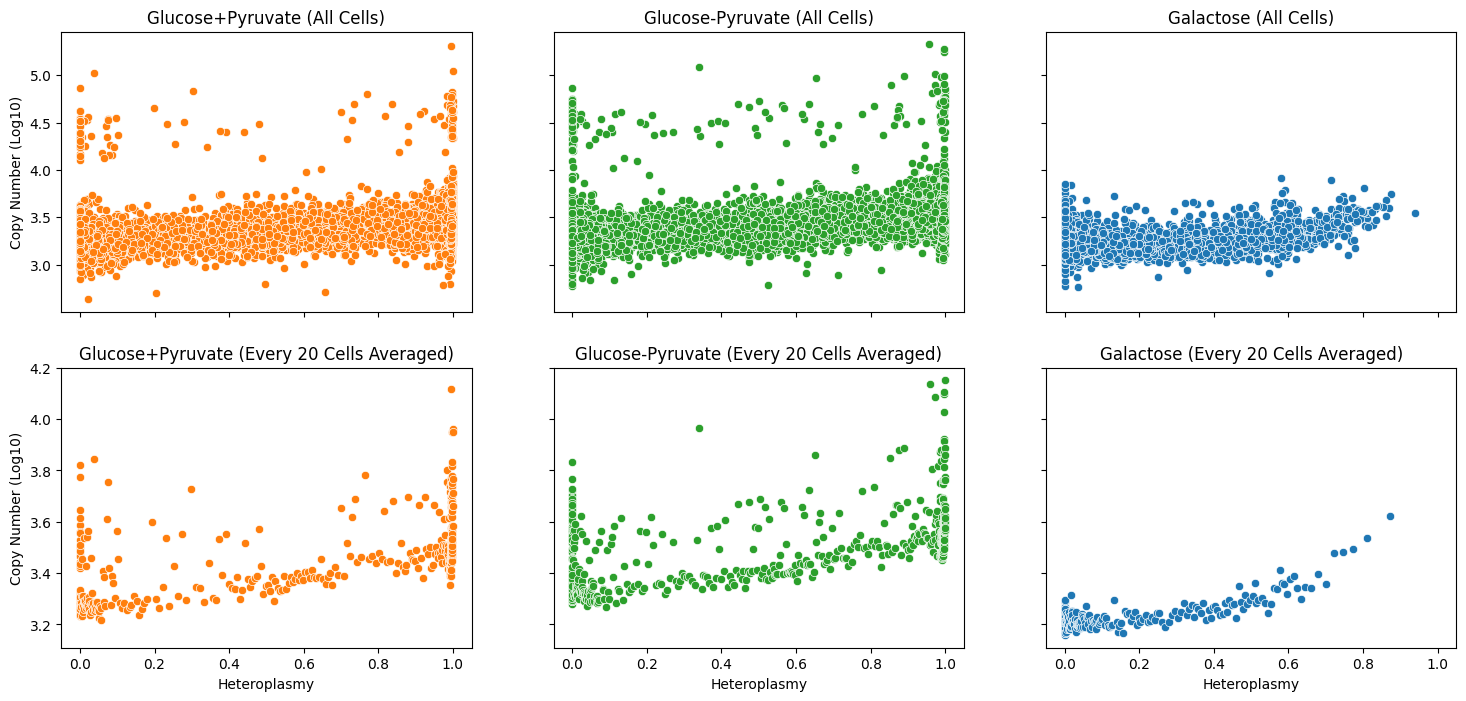

In [19]:
proj_dir = "/data/peer/landm/Projects/sail-dogma/yi-clone-samples/"

num_cols = 3
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows), 
                        sharex = True,
                        sharey = 'row',
                       # gridspec_kw={'hspace': 0.45}
                       )

for j, s in enumerate(samples):
    OUTPUT_DIR = f'../CopyNumberEstimation/CopyNumberEstimation_results/{s}/'
    copy_num_df = pd.read_csv(f'{OUTPUT_DIR}copy_estimates.csv', index_col = 0)
    adata = magic_adatas[s]
    barcodes = [x.split('#')[1] for x in adata.obs_names]
    copy_num = copy_num_df.loc[barcodes].values.flatten()
    copy_num_log = np.log10(copy_num)
    heteroplasmy = adata.obs['heteroplasmy_score'].values
    corr = stats.pearsonr(heteroplasmy, copy_num_log)[0]

    ax = sns.scatterplot(x = heteroplasmy, y = copy_num_log, color = cpal[s], ax = axs[0][j])
    axs[0][j].set(ylabel = 'Copy Number (Log10)', xlabel = 'Heteroplasmy', title = f'{s} (All Cells)')
    
    data = pd.DataFrame([heteroplasmy, copy_num], index = ['heteroplasmy', 'copy_num']).T
    data = data.sort_values('heteroplasmy').reset_index(drop = True)
    binned_data = average_every_n_rows(data, 20)
    binned_data['copy_num_log'] = np.log10(binned_data['copy_num'])
    ax = sns.scatterplot(data = binned_data, x = 'heteroplasmy', y = 'copy_num_log', color = cpal[s], ax = axs[1][j])
    axs[1][j].set(ylabel = 'Copy Number (Log10)', xlabel = 'Heteroplasmy', title = f'{s} (Every 20 Cells Averaged)')
        

## Figure 3F

Next, we plot the gene expression vs heteroplasmy for all mitochondrial genes, normalized for copy number.

In [10]:
mito_genes = ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5',
             'MT-CYB', 'MT-ND6']

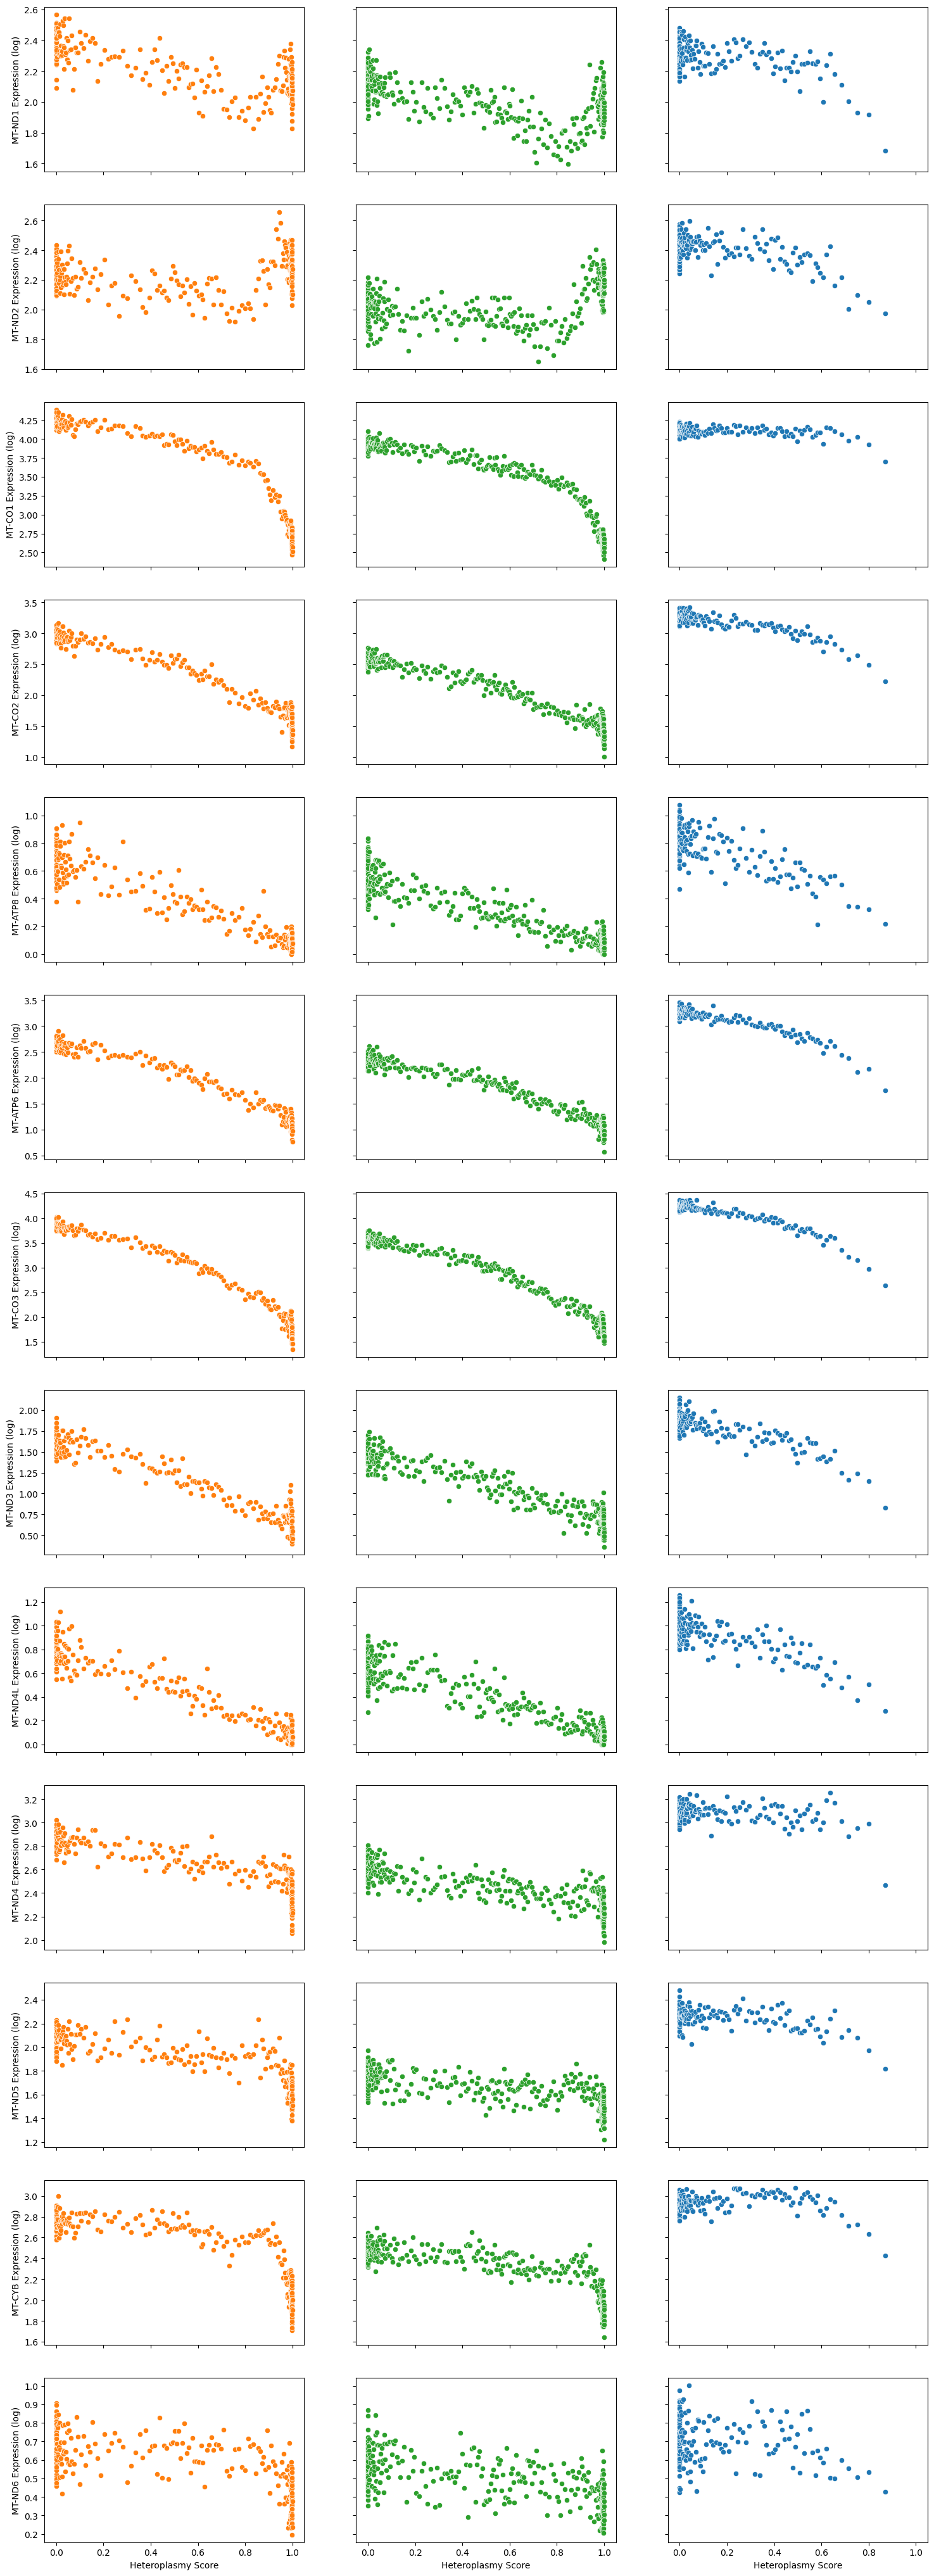

In [20]:
proj_dir = "/data/peer/landm/Projects/sail-dogma/yi-clone-samples/"

num_cols = 3
num_rows = len(mito_genes)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows), 
                        sharex = True,
                        sharey = 'row',
                       # gridspec_kw={'hspace': 0.45}
                       )

for j, s in enumerate(samples):
    OUTPUT_DIR = f'../CopyNumberEstimation/CopyNumberEstimation_results/{s}/'
    copy_num_df = pd.read_csv(f'{OUTPUT_DIR}copy_estimates.csv', index_col = 0)
    adata = magic_adatas[s]
    barcodes = [x.split('#')[1] for x in adata.obs_names]
    copy_num = copy_num_df.loc[barcodes].values.flatten()
    adata.obs['copy_num'] = copy_num

    mtx = adata.layers['median'].toarray()
    copy_scalar = copy_num/np.median(copy_num)
    mtx_scaled = mtx/copy_scalar[:, np.newaxis]
    new_adata = sc.AnnData(X = mtx_scaled)
    new_adata.obs_names = adata.obs_names
    new_adata.var_names = adata.var_names

    for c in ['heteroplasmy_score']:
        new_adata.obs[c] = adata.obs[c]
    
    new_adata.layers['raw_counts'] = new_adata.X
    temp_ad = group_cells_by_heteroplasmy(new_adata, n = 30)
    temp_ad.layers['raw_counts'] = temp_ad.X
    sc.pp.log1p(temp_ad)
    sc.pp.log1p(new_adata)
    for i, gene in enumerate(mito_genes):

        heteroplasmy = temp_ad.obs['heteroplasmy_score']
        gene_count = temp_ad[:, gene].X.toarray().flatten()
        ax = sns.scatterplot(x = heteroplasmy, y = gene_count, ax = axs[i][j], color = cpal[s])
        labels = axs[i][j].set(xlabel = 'Heteroplasmy Score', ylabel = f'{gene} Expression (log)', )


## Figure S7E

We next plot MAGIC imputed gene expression vs heteroplasmy.

In [21]:
mito_genes = ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2']

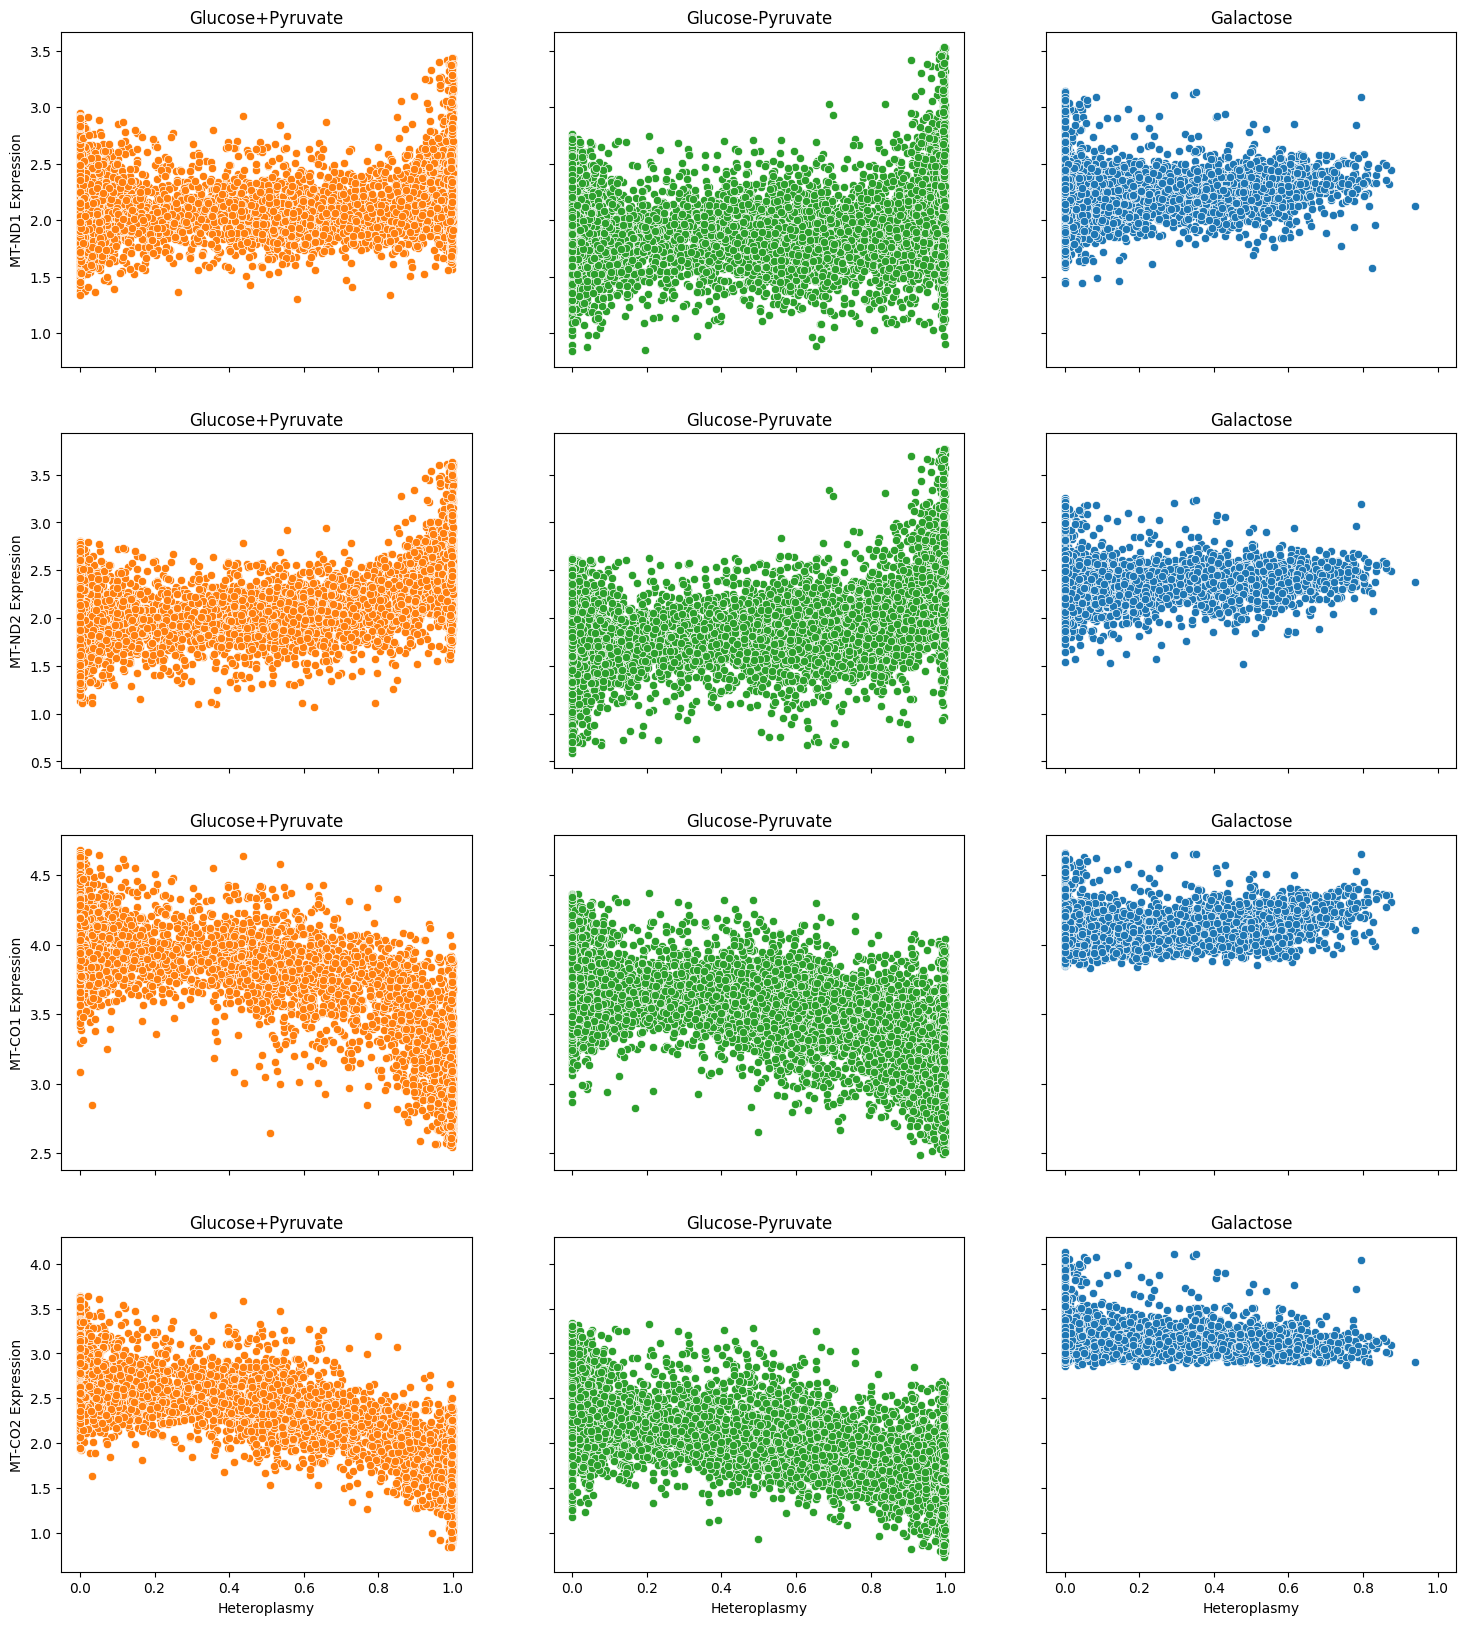

In [22]:
samples = ['Glucose+Pyruvate', 'Glucose-Pyruvate', 'Galactose',]
num_cols = len(samples)
num_rows = len(mito_genes)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows), 
                        sharex = True,
                        sharey = 'row',
                       # gridspec_kw={'hspace': 0.45}
                       )
for i, gene in enumerate(mito_genes):
    for j, s in enumerate(samples):
        heteroplasmy = magic_adatas[s].obs['heteroplasmy_score']
        gene_count = magic_adatas[s][:, gene].layers['magic_imputed'].flatten()
        ax = sns.scatterplot(x = heteroplasmy, y = gene_count, ax = axs[i][j], color = cpal[s])
        ax.set(xlabel = 'Heteroplasmy', 
               ylabel = f'{gene} Expression',
               title = s)


## Figure 4C

We compute the top genes whose expression correlates with heteroplasmy using Spearman and the plot on a heatmap.

In [29]:
all_dfs = []
for s in samples:
    adata = magic_adatas[s].copy()
    sc.pp.filter_genes(adata, min_counts = 10)
    mtx = get_X_asarray(adata.layers['magic_imputed'])

    heteroplasmy_score = adata.obs['heteroplasmy_score'].values

    scores = []
    for i in tqdm(range(mtx.shape[1])):
        temp = []
        temp.append(stats.spearmanr(heteroplasmy_score, mtx[:, i])[0])
        scores.append(temp)
    
    df = pd.DataFrame(scores, columns = [f'{s}_spearman_score'])
    df.index = adata.var_names
    all_dfs.append(df)

100%|██████████| 18551/18551 [00:35<00:00, 523.41it/s]


In [31]:
# Find the union of all indices
all_indices = sorted(set().union(*[df.index for df in all_dfs]))

# Reindex each DataFrame to include all indices, filling missing values with 0
dfs_reindexed = [df.reindex(all_indices, fill_value=0) for df in all_dfs]

# Concatenate the reindexed DataFrames
result = pd.concat(dfs_reindexed, axis=1)
result = result.sort_values('Glucose+Pyruvate_spearman_score')
result = result[['Glucose+Pyruvate_spearman_score', 'Glucose-Pyruvate_spearman_score', 'Galactose_spearman_score']]
result.columns = samples

In [35]:
df = result[(np.abs(result['Glucose+Pyruvate']) > 0.45) & (np.abs(result['Glucose-Pyruvate']) > 0.45)]

In [32]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["#053061", "#2166ac", "#f7f7f7", "#b2182b", "#67001f"]
n_colors = 1001  # Total number of colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_colors)

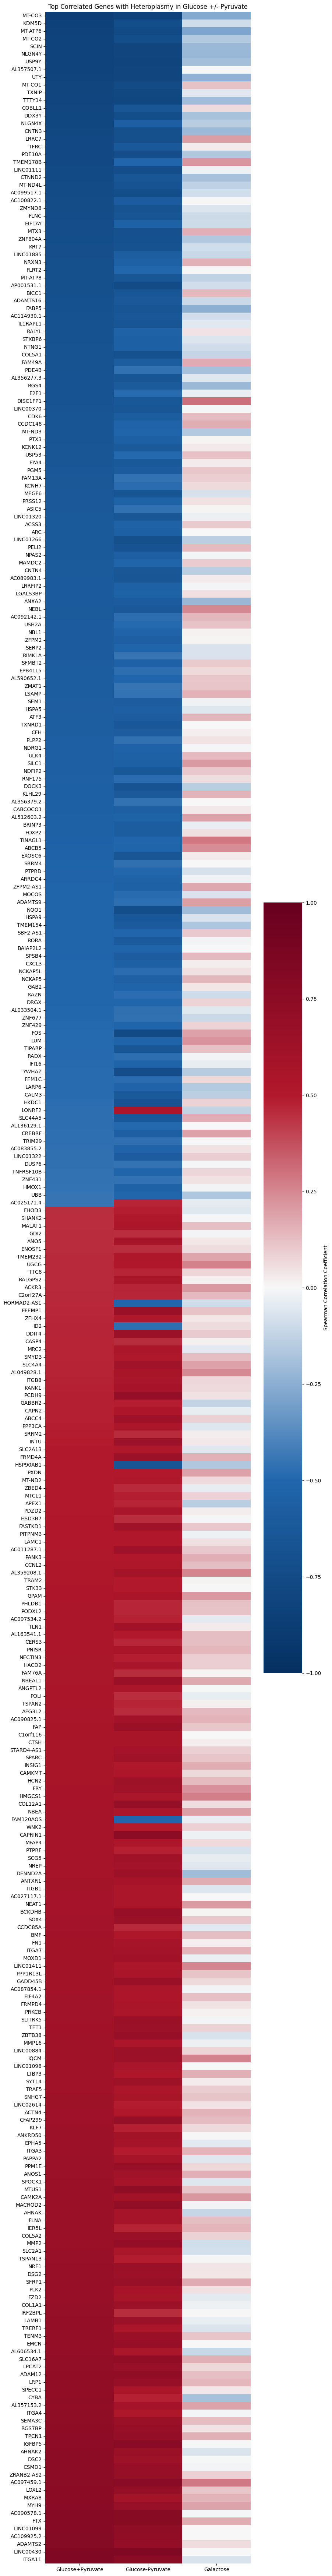

In [36]:
plt.figure(figsize=(9, 90))

ax = sns.heatmap(df, cmap = custom_cmap, vmin = -1, vmax = 1)
title = ax.set(title = 'Top Correlated Genes with Heteroplasmy in Glucose +/- Pyruvate')
xticks = plt.xticks(rotation = 45)
yticks = plt.yticks(rotation = 0)
cbar = ax.collections[0].colorbar
cbar.set_label("Spearman Correlation Coefficient")
xticks = plt.xticks(rotation = 0)

# Categorizing genes as gradual/heteroplasmy sensing or threshold

A description of the analysis is methods section of the manuscript under **Identification of genes correlating with heteroplasmy**

We first divide cells into 0-0.75 and 0.75-1 heteroplasmy categories and compute correlation of each section.

In [7]:
dfs = {}
method = 'magic'
peak = 0.75

for s in ['Glucose+Pyruvate', 'Glucose-Pyruvate']:
    adata_temp = magic_adatas[s].copy()
    sc.pp.filter_genes(adata_temp, min_counts = 10)
    filtered_genes = adata_temp.var_names
    
    # decide which gene exp mode to use
    if method == 'binned':
        adata = meta_adatas[s].copy()
        adata = adata[:, filtered_genes].copy()
        mtx = get_X_asarray(adata.X)
    elif method == 'magic':
        adata = magic_adatas[s].copy()
        adata = adata[:, filtered_genes].copy()
        mtx = get_X_asarray(adata.layers['magic_imputed'])

    heteroplasmy_score = adata.obs['heteroplasmy_score'].values

    scores = []
    for i in tqdm(range(mtx.shape[1])):
        temp = []
        temp.append(stats.pearsonr(heteroplasmy_score, mtx[:, i])[0])
        temp.append(stats.spearmanr(heteroplasmy_score, mtx[:, i])[0])
        scores.append(temp)
    pearson_df = pd.DataFrame(scores, columns = [f'{method}_pearson_score', f'{method}_spearman_score'])
    pearson_df.index = adata.var_names
    corr_df = pearson_df.sort_values(f'{method}_pearson_score', ascending = True)


    low_idx = adata.obs['heteroplasmy_score'] < peak
    high_idx = ~low_idx

    heteroplasmy_score_low = adata[low_idx, :].obs['heteroplasmy_score'].values
    heteroplasmy_score_high = adata[high_idx, :].obs['heteroplasmy_score'].values

    if method == 'binned':
        if issparse(adata.X):
            low_mtx = adata[low_idx, :].X.toarray()
            high_mtx = adata[high_idx, :].X.toarray()
        else:
            low_mtx = adata[low_idx, :].X
            high_mtx = adata[high_idx, :].X
    elif method == 'magic':
        if issparse(adata.layers['magic_imputed']):
            low_mtx = adata[low_idx, :].layers['magic_imputed'].toarray()
            high_mtx = adata[high_idx, :].layers['magic_imputed'].toarray()
        else:
            low_mtx = adata[low_idx, :].layers['magic_imputed']
            high_mtx = adata[high_idx, :].layers['magic_imputed']


    low_scores = []
    high_scores = []

    for i in range(low_mtx.shape[1]):
        low_vals = list(stats.pearsonr(heteroplasmy_score_low, low_mtx[:, i]))
        high_vals = list(stats.pearsonr(heteroplasmy_score_high, high_mtx[:, i]))
        low_vals.append(np.polyfit(heteroplasmy_score_low, low_mtx[:, i], 1)[0])
        high_vals.append(np.polyfit(heteroplasmy_score_high, high_mtx[:, i], 1)[0])

        low_scores.append(low_vals)
        high_scores.append(high_vals)

    low_df = pd.DataFrame(low_scores, columns = ['pearson_score_low', 'pval_low', 'slope_low'])
    low_df.index = adata.var_names
    high_df = pd.DataFrame(high_scores, columns = ['pearson_score_high', 'pval_high', 'slope_high'])
    high_df.index = adata.var_names

    pearson_df = pd.concat([low_df, high_df], axis = 1)
    # corr_df.to_csv(f'pearson_spearman_slope_{s}_split_{peak}.csv')

    corr_df[f'{method}_slope_0_to_{peak}'] = pearson_df.loc[corr_df.index]['slope_low']
    corr_df[f'{method}_slope_{peak}_to_1'] = pearson_df.loc[corr_df.index]['slope_high']
    dfs[s] = corr_df.copy()

100%|██████████| 19356/19356 [01:28<00:00, 218.97it/s]


In [8]:
for s, df in dfs.items():
    arr = []
    for x in df['magic_spearman_score']:
        if x > 0:
            arr.append('up')
        elif x < 0:
            arr.append('down')
        else:
            arr.append('zero')
    df['direction'] = arr

Next we filter and keep genes with spearman correlation < 0.3 or > -0.3.

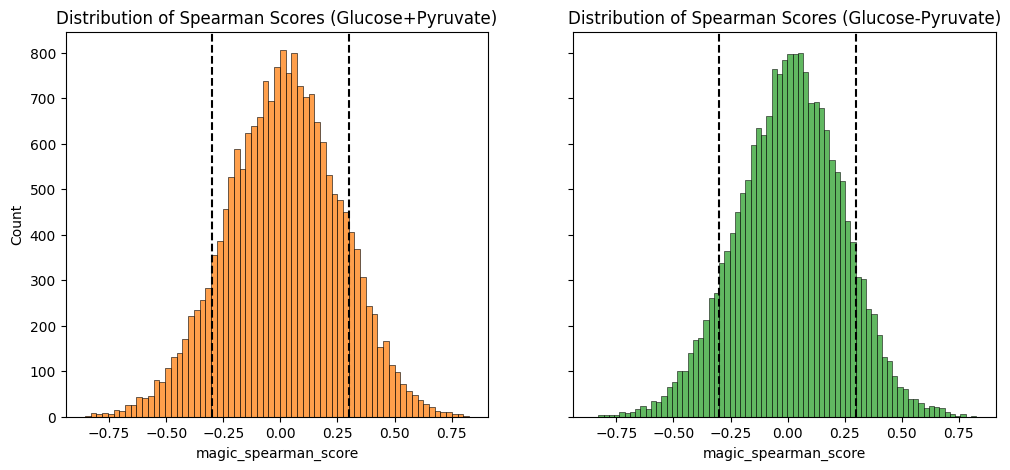

In [9]:
peak = 0.75

num_cols = len(dfs)
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows), 
                        sharex = True,
                        sharey = 'row',
                       # gridspec_kw={'hspace': 0.45}
                       )

for items, ax in zip(dfs.items(), axs.reshape(-1)):
    s, df = items
    ax = sns.histplot(df['magic_spearman_score'], ax = ax, color = cpal[s])
    text = ax.set(title = f'Distribution of Spearman Scores ({s})')
    vline = ax.axvline(x = 0.3, linestyle = '--', color = 'black')
    vline = ax.axvline(x = -0.3, linestyle = '--', color = 'black')

Next, we compute and sort genes based on log fold change. 

threshold genes have lfc > 2

gradual genes have -2 < lfc < 2

In [10]:
for s, df in dfs.items():
    dfs[s] = df[np.abs(df['magic_spearman_score'])>= 0.3].copy()
    dfs[s]['log2fc'] = np.log2(np.abs(df['magic_slope_0.75_to_1'])/np.abs(df['magic_slope_0_to_0.75']))

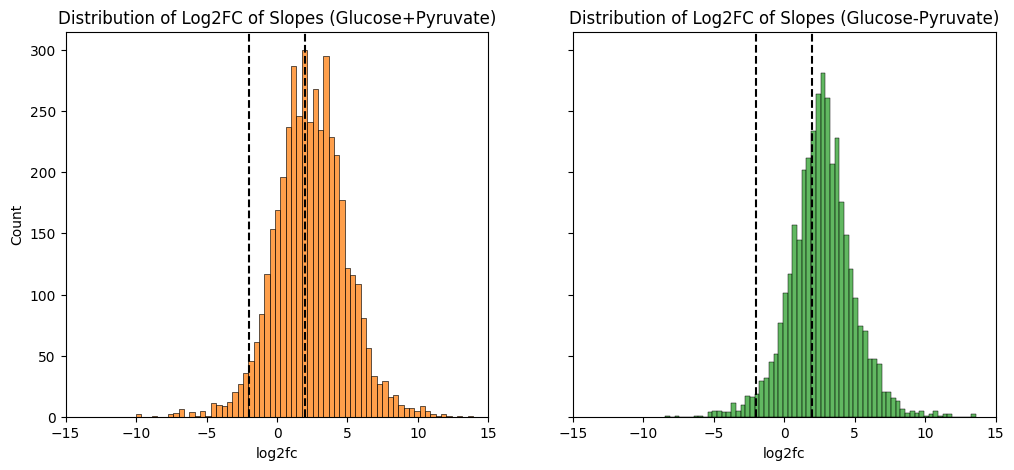

In [11]:
num_cols = len(dfs)
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows), 
                        sharex = True,
                        sharey = 'row',
                       # gridspec_kw={'hspace': 0.45}
                       )

for items, ax in zip(dfs.items(), axs.reshape(-1)):
    s, df = items
    ax = sns.histplot(df['log2fc'], ax = ax, color = cpal[s])
    text = ax.set(title = f'Distribution of Log2FC of Slopes ({s})', xlim = (-15, 15))
    vline = ax.axvline(x = 2, linestyle = '--', color = 'black')
    vline = ax.axvline(x = -2, linestyle = '--', color = 'black')

In [12]:
gradual_dfs = {}
threshold_dfs = {}

for s, df in dfs.items():
    threshold_dfs[s] = df[df['log2fc'] >= 2].copy()
    gradual_dfs[s] = df[np.abs(df['log2fc']) < 2].copy()

In [14]:
for s, df in threshold_dfs.items():
    out_dir = f'./gene-heteorplasmy-corr-results/{s}/'
    temp = df[np.abs(df['magic_slope_0.75_to_1']) >= 0.1].sort_values('log2fc')
    temp[temp['direction'] == 'up'].to_csv(f'{out_dir}threshold_up_peak_{peak}.csv')
    temp[temp['direction'] == 'down'].to_csv(f'{out_dir}threshold_down_peak_{peak}.csv')

In [15]:
for s, df in gradual_dfs.items():
    out_dir = f'./gene-heteorplasmy-corr-results/{s}/'
    temp = df[(np.abs(df['magic_slope_0.75_to_1']) >= 0.05) |
           (np.abs(df['magic_slope_0_to_0.75']) >= 0.05)].sort_values('log2fc')
    temp[temp['direction'] == 'up'].to_csv(f'{out_dir}gradual_up_peak_{peak}.csv')
    temp[temp['direction'] == 'down'].to_csv(f'{out_dir}gradual_down_peak_{peak}.csv')

## Figure 4d

We plot the genes categorized in the above analysis.

In [80]:
from sklearn.linear_model import LinearRegression


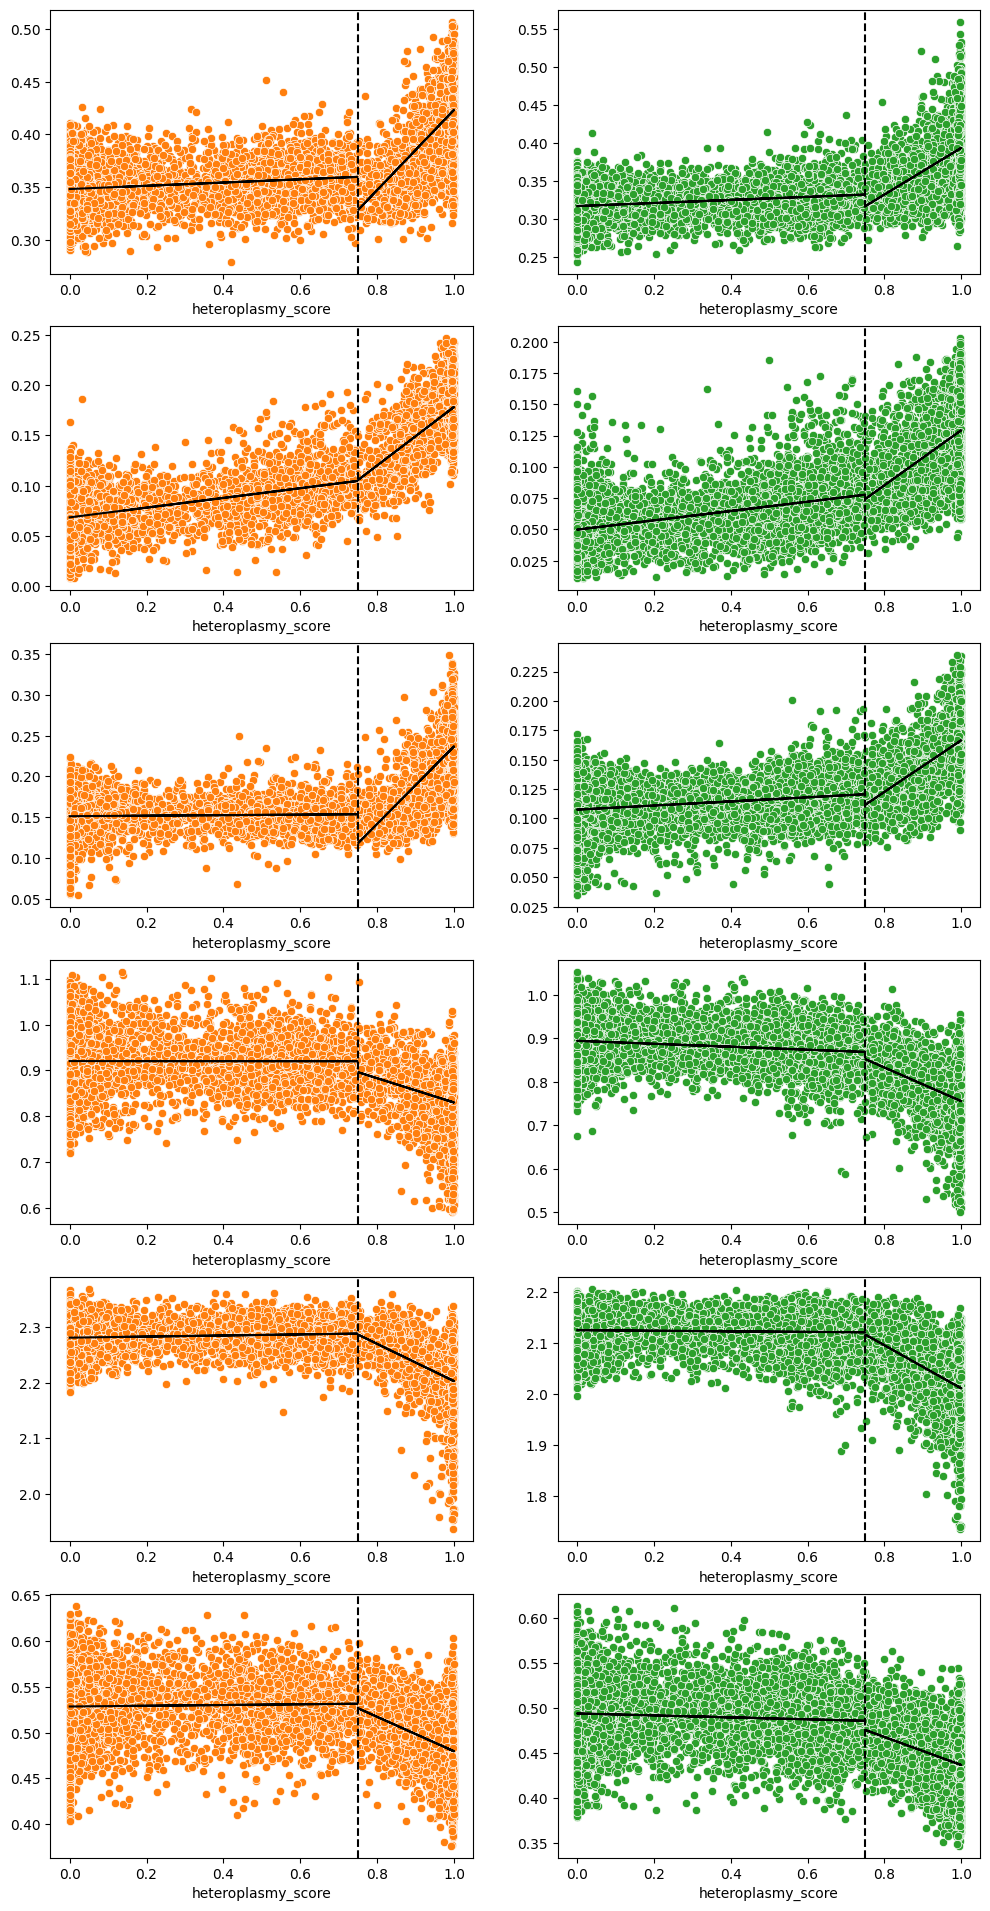

In [81]:
genes = ['NRF1', 'ITGA11', 'MMP2', 'HKDC1', 'TXNRD1', 'TNFRSF10B']

num_cols = 2
num_rows = len(genes)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows), 
                        sharex = False,
                        sharey = False,
                       # gridspec_kw={'hspace': 0.45}
                      )
for i, s in enumerate(['Glucose+Pyruvate', 'Glucose-Pyruvate']):
    for j, gene in enumerate(genes):
        heteroplasmy = magic_adatas[s].obs['heteroplasmy_score']
        gene_count = magic_adatas[s][:, gene].layers['magic_imputed'].flatten()
        ax = sns.scatterplot(x = heteroplasmy, y = gene_count, ax = axs[j][i], color = cpal[s])
        range1 = heteroplasmy <= 0.75
        range2 = heteroplasmy > 0.75

        # Perform linear regression for range 0 - 0.75
        x1 = heteroplasmy[range1].values.reshape(-1, 1)
        y1 = gene_count[range1]
        reg1 = LinearRegression().fit(x1, y1)
        y1_pred = reg1.predict(x1)
        axs[j][i].plot(x1, y1_pred, color='black')

        # Perform linear regression for range 0.75 - 1
        x2 = heteroplasmy[range2].values.reshape(-1, 1)
        y2 = gene_count[range2]
        reg2 = LinearRegression().fit(x2, y2)
        y2_pred = reg2.predict(x2)
        axs[j][i].plot(x2, y2_pred, color='black')

        axs[j][i].axvline(x = 0.75, color = 'black', linestyle = '--')

## Figure 4e

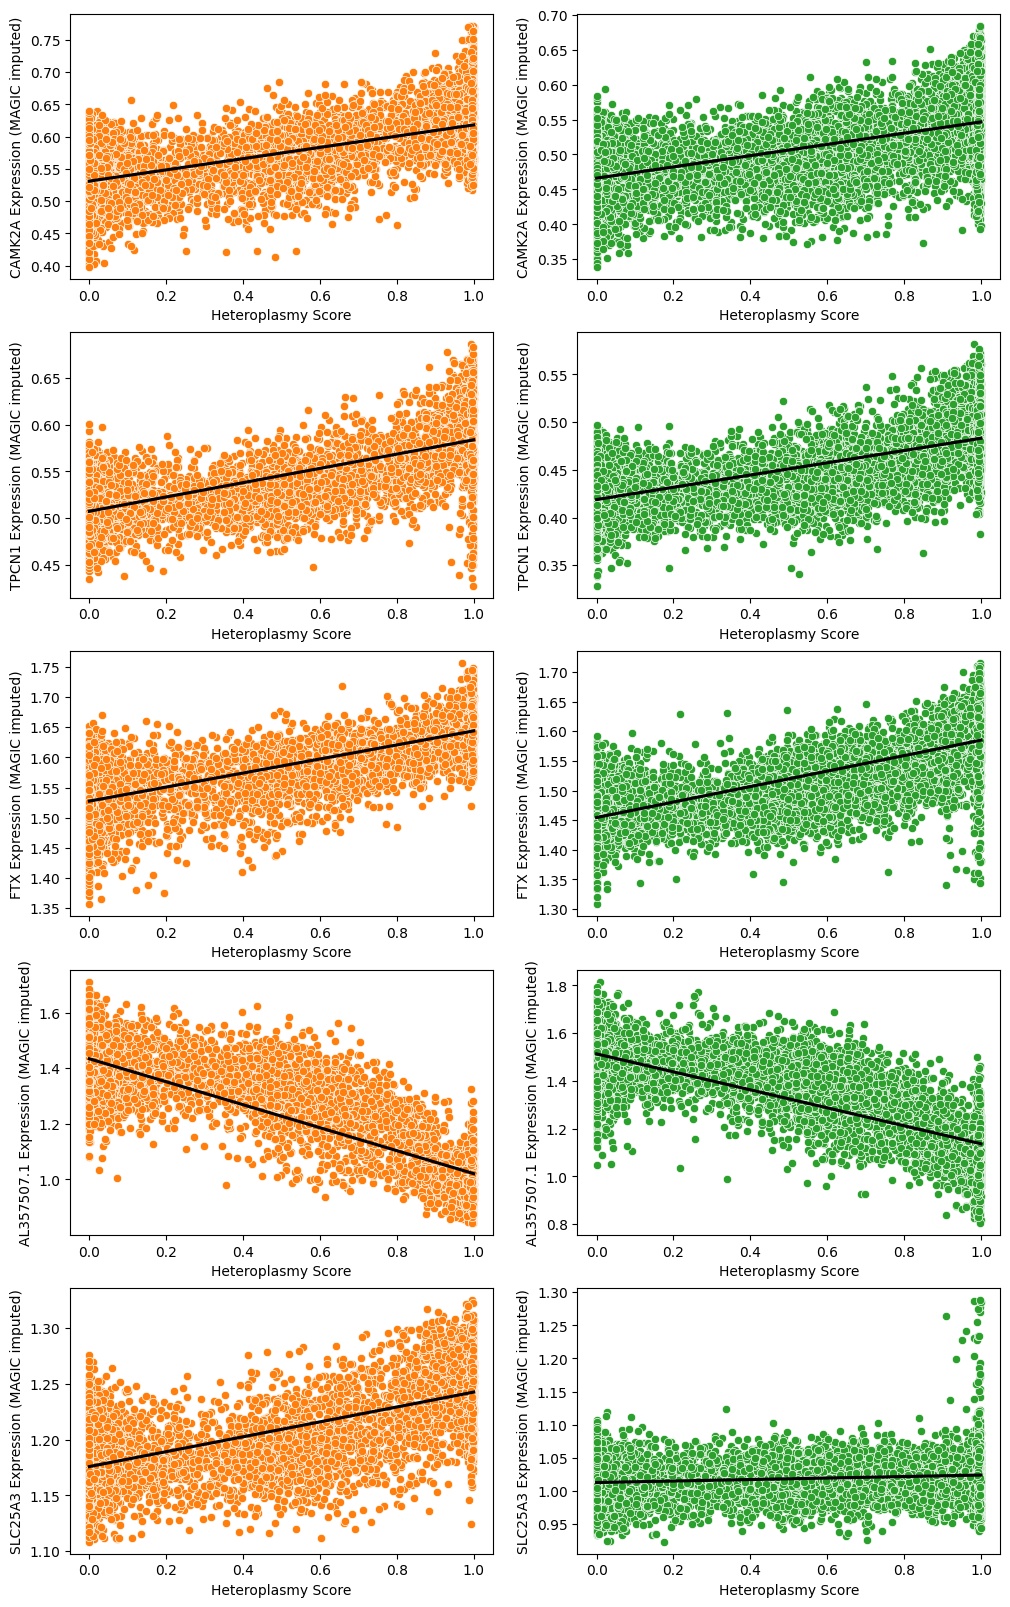

In [83]:
genes = ['CAMK2A', 'TPCN1', 'FTX', 'AL357507.1', 'SLC25A3']

num_cols = 2
num_rows = len(genes)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows), 
                        sharex = False,
                        sharey = False,
                       # gridspec_kw={'hspace': 0.45}
                      )
for i, s in enumerate(['Glucose+Pyruvate', 'Glucose-Pyruvate']):
    for j, gene in enumerate(genes):
        heteroplasmy = magic_adatas[s].obs['heteroplasmy_score']
        gene_count = magic_adatas[s][:, gene].layers['magic_imputed'].flatten()
        ax = sns.scatterplot(x = heteroplasmy, y = gene_count, ax = axs[j][i], color = cpal[s])
        ax = sns.regplot(x = heteroplasmy, y = gene_count, ax = axs[j][i], scatter = False, color = 'black')
        labels = ax.set(xlabel = 'Heteroplasmy Score', ylabel = f'{gene} Expression (MAGIC imputed)', 
              title = None)

## Figure S8C

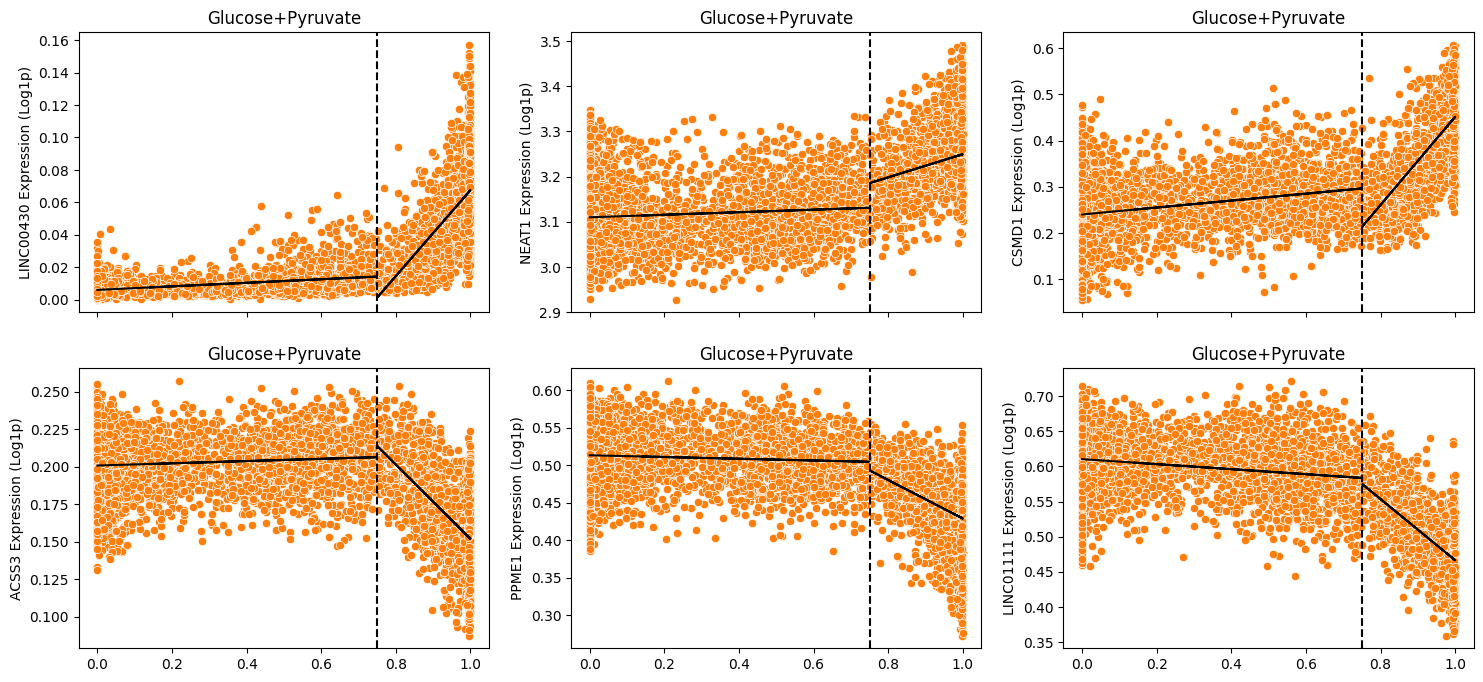

In [87]:
genes = ['LINC00430', 'NEAT1', 'CSMD1', 'ACSS3', 'PPME1', 'LINC01111']

num_cols = 3
num_rows = len(genes)//num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows), 
                        sharex = True,
                        sharey = False,
                       # gridspec_kw={'hspace': 0.45}
                       )
s = 'Glucose+Pyruvate'

for gene, ax in zip(genes, axs.reshape(-1)):
    
    heteroplasmy = magic_adatas[s].obs['heteroplasmy_score']
    gene_count = magic_adatas[s][:, gene].layers['magic_imputed'].flatten()
    temp = sns.scatterplot(x = heteroplasmy, y = gene_count, ax = ax, color = cpal[s])
    ax.set(xlabel = '', ylabel = f'{gene} Expression (Log1p)', title = s)

    range1 = heteroplasmy <= 0.75
    range2 = heteroplasmy > 0.75

    # Perform linear regression for range 0 - 0.75
    x1 = heteroplasmy[range1].values.reshape(-1, 1)
    y1 = gene_count[range1]
    reg1 = LinearRegression().fit(x1, y1)
    y1_pred = reg1.predict(x1)
    ax.plot(x1, y1_pred, color='black')

    # Perform linear regression for range 0.75 - 1
    x2 = heteroplasmy[range2].values.reshape(-1, 1)
    y2 = gene_count[range2]
    reg2 = LinearRegression().fit(x2, y2)
    y2_pred = reg2.predict(x2)
    ax.plot(x2, y2_pred, color='black')

    ax.axvline(x = 0.75, color = 'black', linestyle = '--')

## Figure S8D

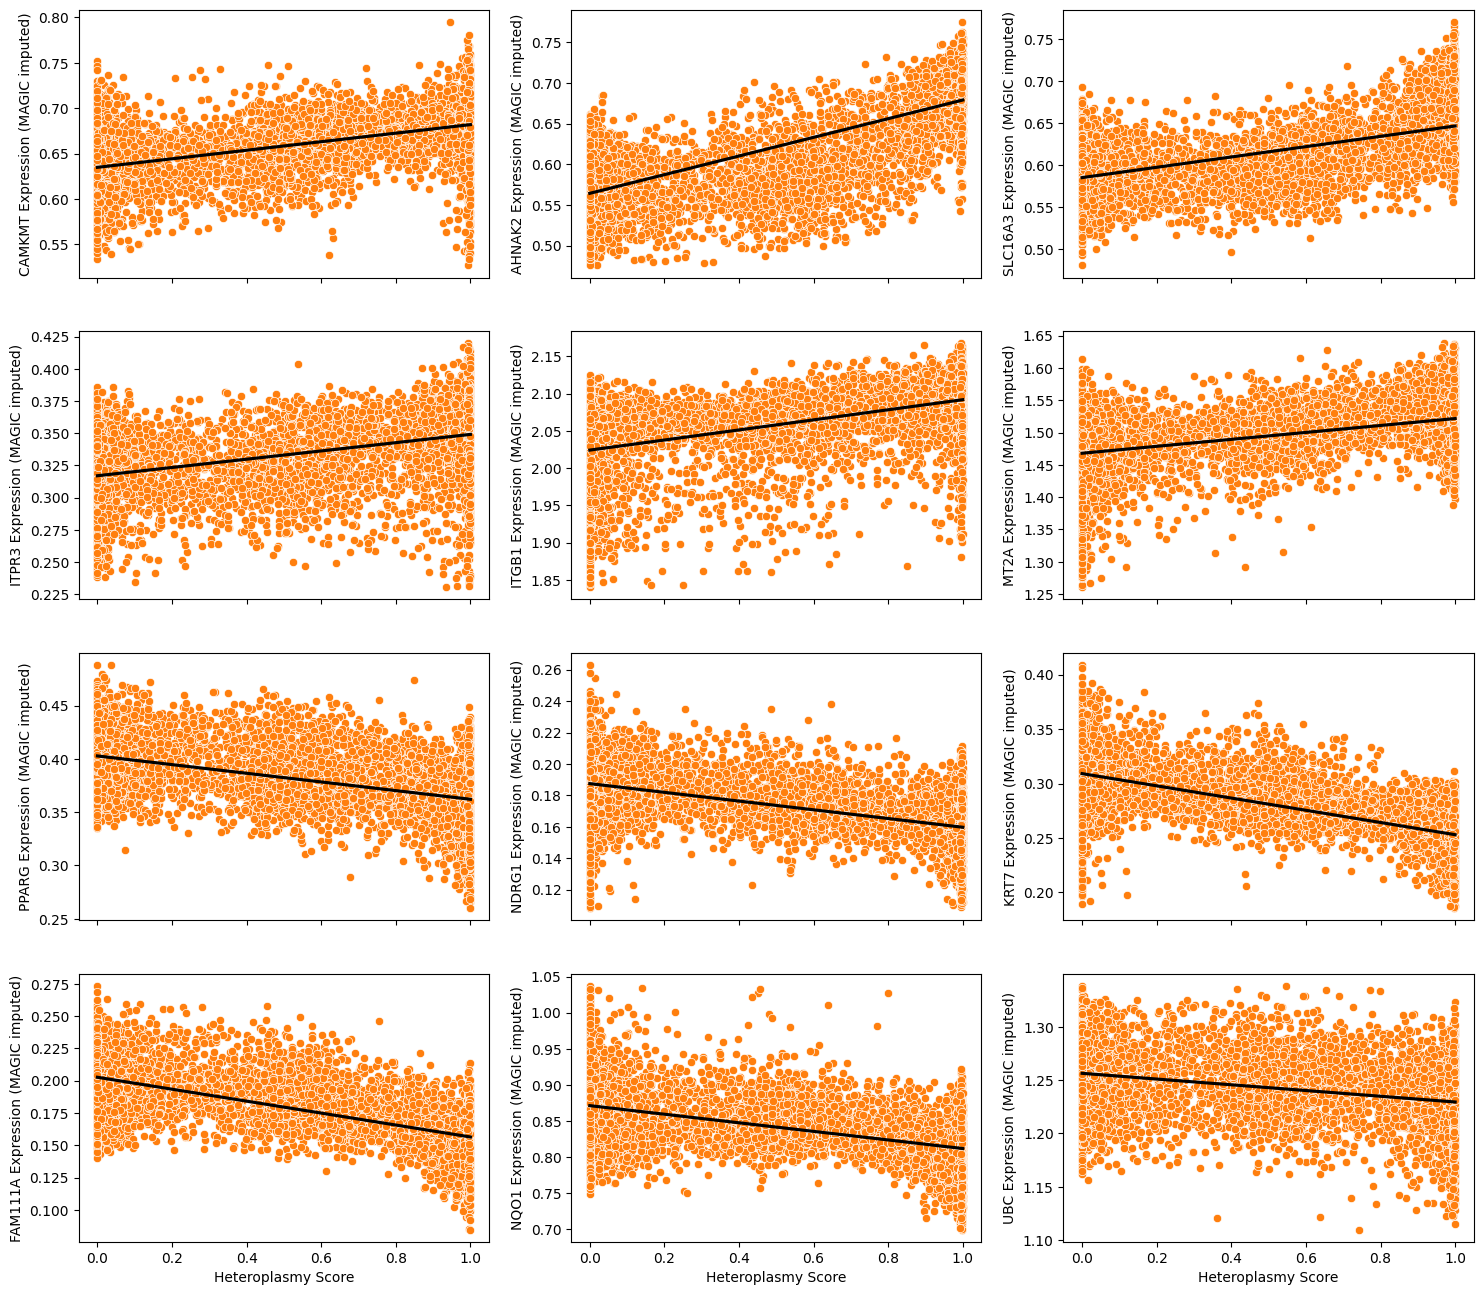

In [89]:
genes = ['CAMKMT', 'AHNAK2', 'SLC16A3', 'ITPR3', 'ITGB1', 'MT2A', 'PPARG', 'NDRG1', 'KRT7', 'FAM111A', 'NQO1', 'UBC']

num_cols = 3
num_rows = len(genes)//num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows), 
                        sharex = True,
                        sharey = False,
                       # gridspec_kw={'hspace': 0.45}
                       )
for gene, ax in zip(genes, axs.reshape(-1)):

    heteroplasmy = magic_adatas[s].obs['heteroplasmy_score']
    gene_count = magic_adatas[s][:, gene].layers['magic_imputed'].flatten()
    temp = sns.scatterplot(x = heteroplasmy, y = gene_count, ax = ax, color = cpal[s])
    ax.set(xlabel = '', ylabel = f'{gene} Expression (Log1p)', title = s)
    ax = sns.regplot(x = heteroplasmy, y = gene_count, ax = ax, scatter = False, color = 'black')
    labels = ax.set(xlabel = 'Heteroplasmy Score', ylabel = f'{gene} Expression (MAGIC imputed)', 
          title = None)